In [2]:
import math
math.tanh(-2.2) 

-0.9757431300314515

In [3]:
math.tanh(0.1)

0.09966799462495582

In [4]:
math.tanh(2.5)

0.9866142981514303

### 先匯入第5章的溫度資料及事先操作

In [5]:
import torch

In [6]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]  # 攝氏溫度
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]  # 溫度計上對應到的數值
t_c = torch.tensor(t_c).unsqueeze(1) # 將資料集打包成張量，會在第1個維度（也就是列維度）增加一個維度，使張量從一維變為二維。這樣做是因為 PyTorch 的模型通常期望輸入是二維或更高維度的資料，形狀為 (n_samples, n_features)
t_u = torch.tensor(t_u).unsqueeze(1) 

t_u.shape # 形狀會是 (n_samples, 1)，其中 n_samples 是樣本數量，1 是特徵的數量（因為每個樣本只有一個特徵）

torch.Size([11, 1])

In [7]:
n_samples = t_u.shape[0] # 取得了 t_u 的第一個維度的大小，代表樣本的數量，並將其賦值給變數 n_samples
n_val = int(0.2 * n_samples) # 計算驗證集樣本的數量，假設我們希望將 20% 的數據用作驗證集。int(0.2 * n_samples) 會計算樣本數的 20% 並轉換為整數

shuffled_indices = torch.randperm(n_samples) # 生成一個隨機排列的索引序列。這樣的排列可以打亂數據集，為隨機分割訓練集和驗證集做準備

# 根據隨機排列的索引將資料集分為訓練集和驗證集
train_indices = shuffled_indices[:-n_val] # 隨機排列後的索引序列中的前 n_samples - n_val 個作為訓練集的索引
val_indices = shuffled_indices[-n_val:]   # 取隨機排列後的索引序列中的最後 n_val 個作為驗證集的索引

train_indices, val_indices    # 將數據集分為訓練集和驗證集

(tensor([ 8,  7,  3,  5,  2,  1,  4,  6, 10]), tensor([0, 9]))

In [8]:
t_u_train = t_u[train_indices] #訓練資料集
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices] #驗證資料集
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train #進行正規化
t_un_val = 0.1 * t_u_val

In [28]:
t_un_val

tensor([[3.5700],
        [6.0400]])

### 回到6.2.2節的程式

In [9]:
import torch.nn as nn
linear_model = nn.Linear(1, 1) #參數分別表示：輸入特徵數量及輸出特徵數量（bias參數並未列出，代表使用預設值True) 
linear_model(t_un_val) #參數為要輸入模型的驗證集資料

tensor([[1.7470],
        [3.1476]], grad_fn=<AddmmBackward0>)

In [10]:
linear_model.weight #輸出當前的權重值

Parameter containing:
tensor([[0.5670]], requires_grad=True)

In [11]:
linear_model.bias #輸出當前的偏值

Parameter containing:
tensor([-0.2773], requires_grad=True)

In [12]:
x = torch.ones(1)
linear_model(x)

tensor([0.2897], grad_fn=<AddBackward0>)

In [13]:
x = torch.ones(10, 1) #x為批次的輸入資料（一個批次內有10筆樣本）
linear_model(x)

tensor([[0.2897],
        [0.2897],
        [0.2897],
        [0.2897],
        [0.2897],
        [0.2897],
        [0.2897],
        [0.2897],
        [0.2897],
        [0.2897]], grad_fn=<AddmmBackward0>)

In [14]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) #在第1軸增加一軸（維度固定為1）
t_u = torch.tensor(t_u).unsqueeze(1) 
t_u.shape

torch.Size([11, 1])

In [15]:
linear_model = nn.Linear(1, 1) #利用nn模組替換第5章的線性模型
optimizer = torch.optim.SGD(linear_model.parameters(), #利用parameters()取代之前的『params』
                            lr=1e-2 #學習率
                            )

In [16]:
linear_model.parameters()

<generator object Module.parameters at 0x0000028B38FEBA50>

In [17]:
list(linear_model.parameters()) #輸出參數串列中的元素

[Parameter containing:
 tensor([[-0.6175]], requires_grad=True),
 Parameter containing:
 tensor([-0.5567], requires_grad=True)]

In [32]:
def training_loop(n_epochs,optimizer,model,loss_fn,t_u_train,t_u_val,t_c_train,t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)  # 溫度計的訓練資料丟入Linear model
        loss_train = loss_fn(t_p_train,t_c_train) # 丟入model後溫度計資料與原始攝氏溫度資料的loss

        t_p_val = model(t_u_val) # 溫度計的驗證資料丟入Linear model
        loss_val = loss_fn(t_p_val,t_c_val) # 丟入model後溫度計資料與原始攝氏溫度資料的loss

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"  #印出訓練損失及驗證損失
                  f"validation loss {loss_val.item():}")


In [33]:
linear_model = nn.Linear(1, 1)
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1e-2)#定義優化器
training_loop(
    n_epochs = 3000,#進行3000次訓練 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), #此處不再使用手寫的損失函數
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 107.9031,validation loss 35.036216735839844
Epoch 1000, Training loss 3.4389,validation loss 6.850359916687012
Epoch 2000, Training loss 2.7456,validation loss 4.967846870422363
Epoch 3000, Training loss 2.7254,validation loss 4.726088047027588
Parameter containing:
tensor([[5.3273]], requires_grad=True)
Parameter containing:
tensor([-16.6987], requires_grad=True)


In [35]:
# 神經網路
seq_model = nn.Sequential(nn.Linear(1,13), # 指定模組中要有13個神經元
                          nn.Tanh(),
                          nn.Linear(13,1)) #此層的第0軸必須和上一層的第1軸相同，皆為13

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [21]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [22]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


#### 自行替 layer 命名

In [23]:
from collections import OrderedDict #匯入相關模組
seq_model = nn.Sequential(OrderedDict([ 
    ('hidden_linear', nn.Linear(1, 13)), #將第1個模組命名為hidden_linear
    ('hidden_activation', nn.Tanh()), #將第2個模組命名為hidden_activation
    ('output_linear', nn.Linear(13, 1)) #將第3個模組命名為output_linear
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [24]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([13, 1])
hidden_linear.bias torch.Size([13])
output_linear.weight torch.Size([1, 13])
output_linear.bias torch.Size([1])


In [25]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1640], requires_grad=True)

In [26]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-3) #這裡為了讓結果更穩定，稍微將學習率調低了一點
training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad) #印出隱藏層中所有weight參數的梯度

Epoch 1, Training loss 228.3850, Validation loss 95.9158
Epoch 1000, Training loss 4.0655, Validation loss 4.5932
Epoch 2000, Training loss 2.9828, Validation loss 9.5657
Epoch 3000, Training loss 1.8680, Validation loss 6.8419
Epoch 4000, Training loss 1.6822, Validation loss 6.5151
Epoch 5000, Training loss 1.4640, Validation loss 5.5708
output tensor([[ 1.9838],
        [15.2319]], grad_fn=<AddmmBackward0>)
answer tensor([[ 0.5000],
        [13.0000]])
hidden tensor([[-5.7987],
        [-0.1944],
        [ 0.0481],
        [-7.3306],
        [-0.1985],
        [ 0.3021],
        [-0.0159],
        [ 6.8785],
        [-6.9379],
        [ 0.2701],
        [-6.3968],
        [-0.1888],
        [ 2.9380]])


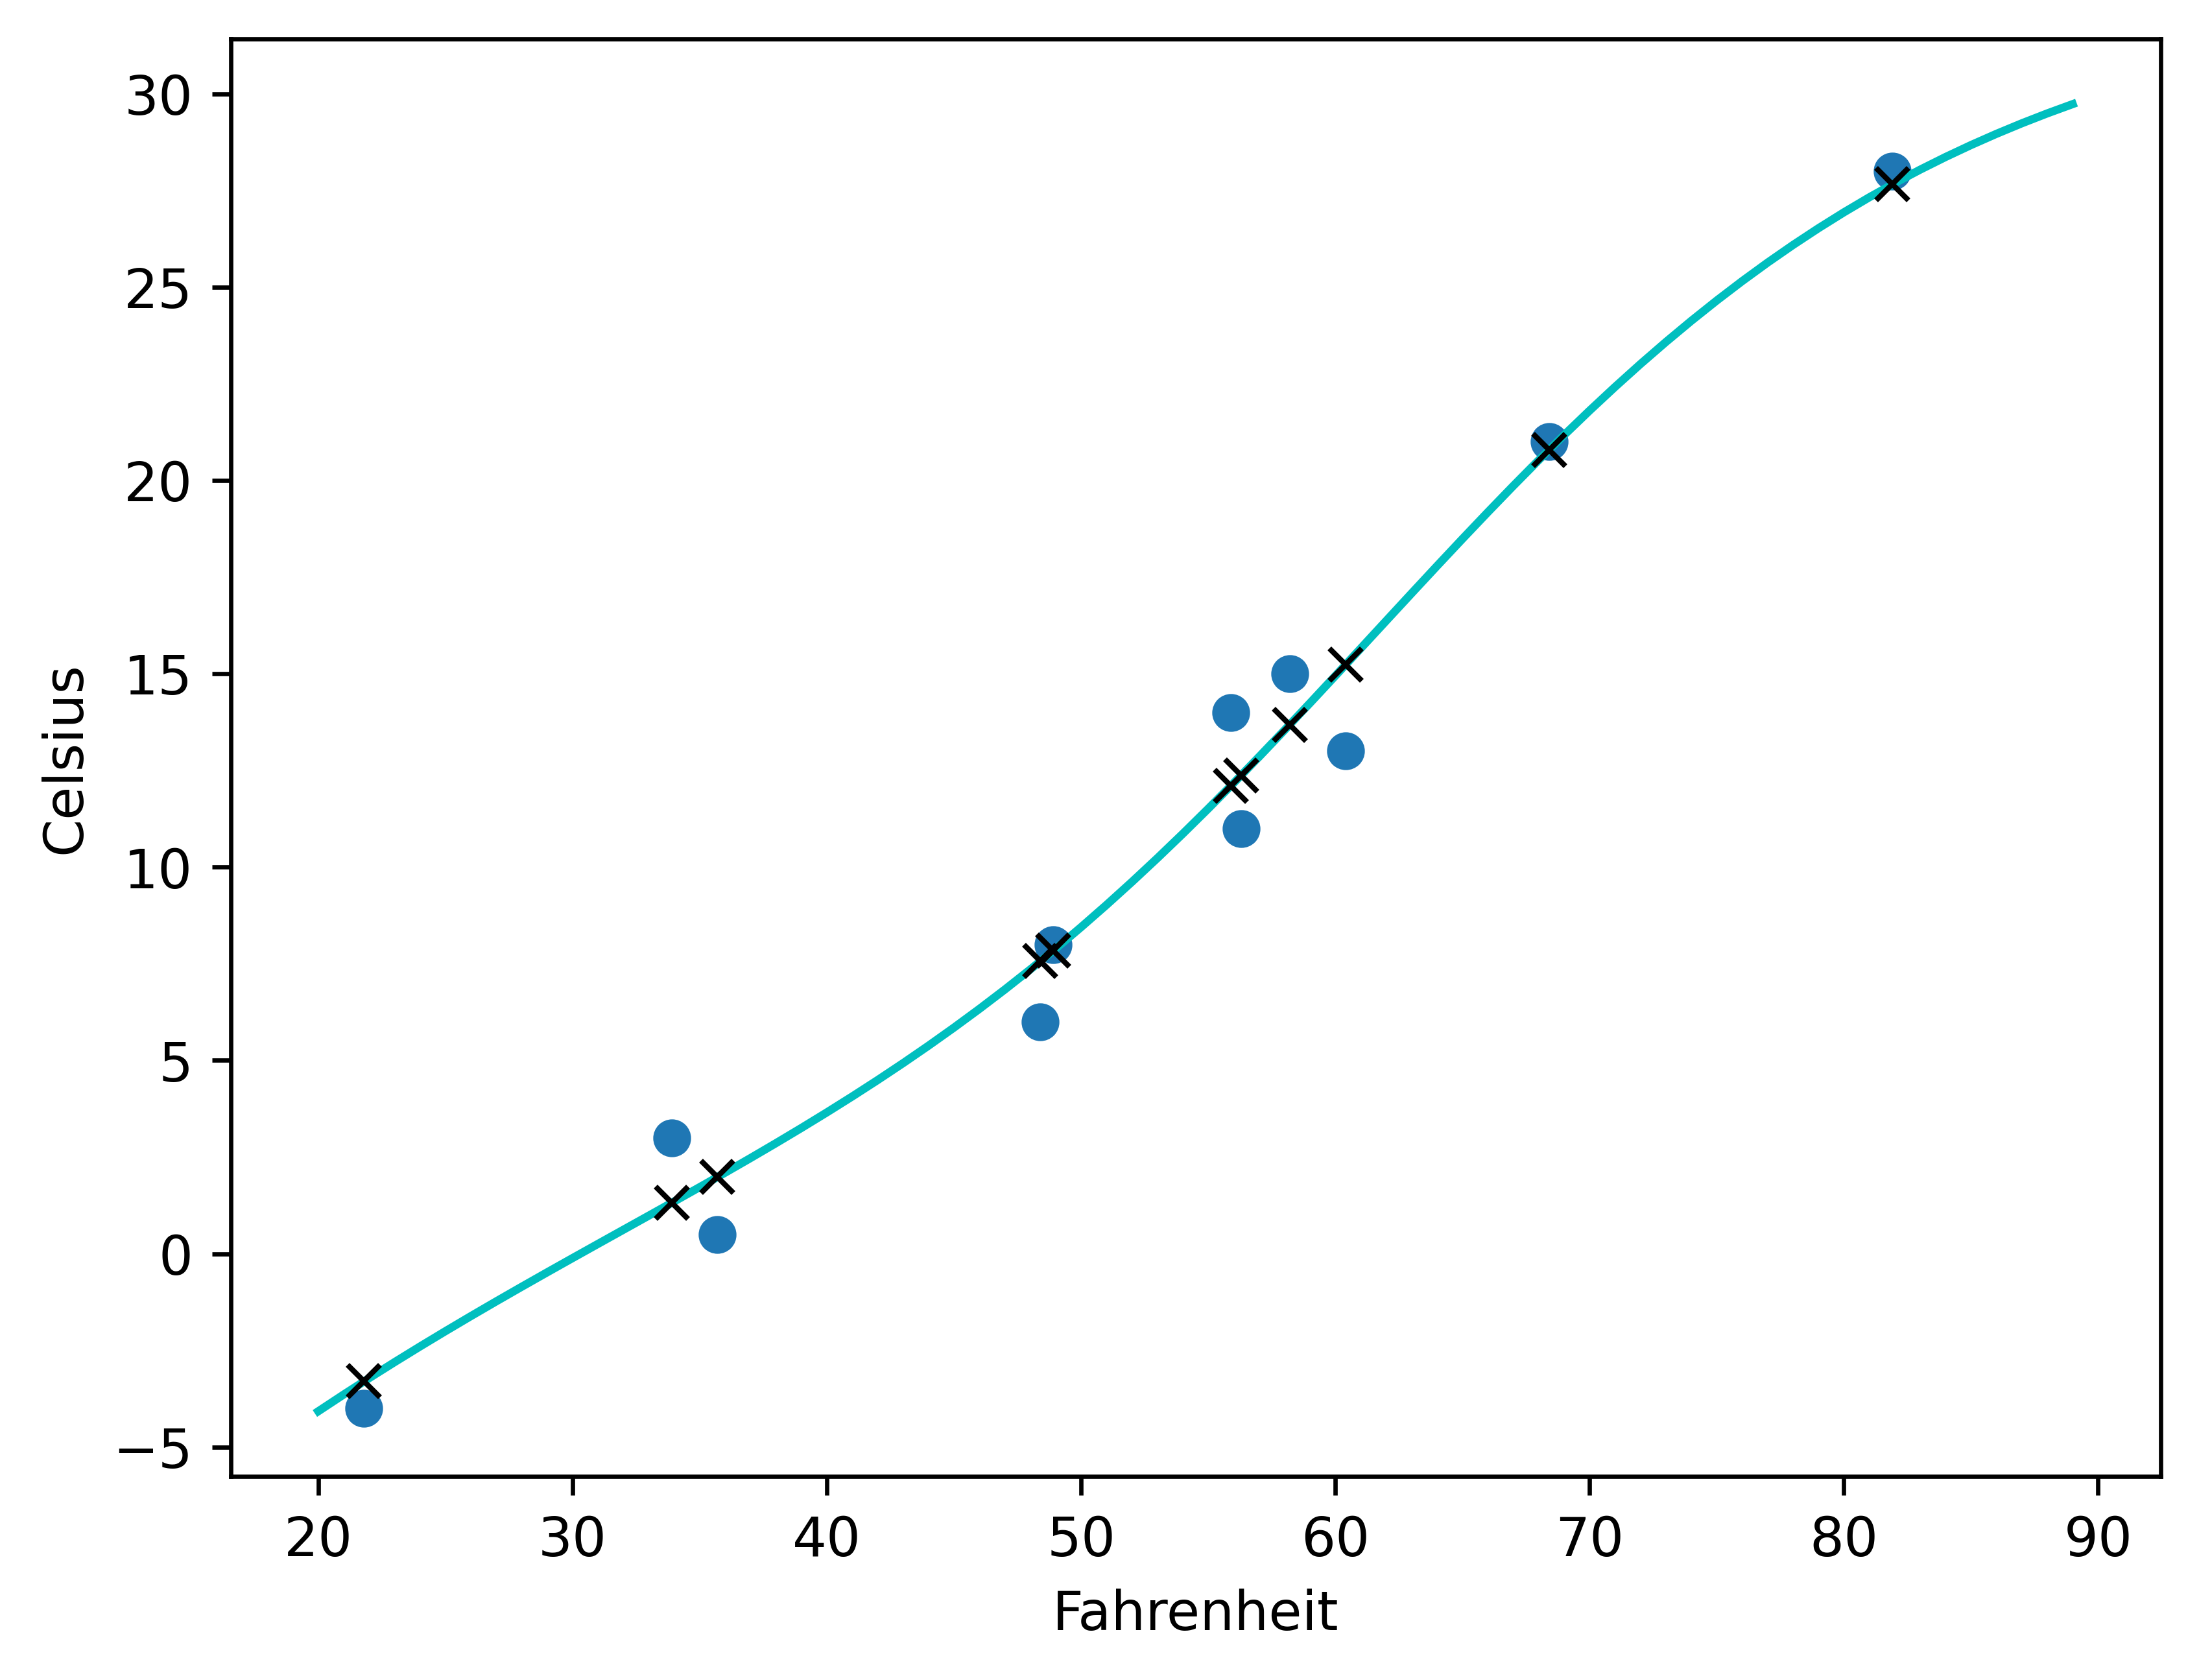

In [27]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o') #描繪出真實的資料點
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-') #描繪出圖6.9的曲線
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx') #描繪出預測的資料點